In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

In [6]:
df = pd.read_excel("/content/sample_data/mlb_final.xlsx")
df.rename(columns={"Unnamed: 0": "Index"}, inplace=True)

In [7]:
df_clean = df.dropna(subset=['Year', 'Attendance'])

In [8]:
df_clean.reset_index(drop=True, inplace=True)


print(df_clean.head())
print(df_clean.info())

   Index Team  Year  Attendance League   RS   RA   W    OBP    SLG     BA  \
0      0  ATL  1990      980129     NL  682  821  65  0.311  0.396  0.250   
1      1  BAL  1990     2415189     AL  669  698  76  0.330  0.370  0.245   
2      2  BOS  1990     2528986     AL  699  664  88  0.344  0.395  0.272   
3      3  CHC  1990     2243791     NL  690  774  77  0.314  0.392  0.263   
4      4  CHW  1990     2002357     AL  682  633  94  0.320  0.379  0.258   

   Playoffs  RankSeason  RankPlayoffs    G  OOBP  OSLG  
0         0         NaN           NaN  162   NaN   NaN  
1         0         NaN           NaN  161   NaN   NaN  
2         1         4.0           3.0  162   NaN   NaN  
3         0         NaN           NaN  162   NaN   NaN  
4         0         NaN           NaN  162   NaN   NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0  

In [9]:
df_clean = df.dropna(subset=['RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG'])
df_clean.reset_index(drop=True, inplace=True)


In [11]:
df['RankSeason'] = df['RankSeason'].fillna(0)
df['RankPlayoffs'] = df['RankPlayoffs'].fillna(0)
df['OOBP'] = df['OOBP'].fillna(df['OBP'])
df['OSLG'] = df['OSLG'].fillna(df['SLG'])
df = df.drop(columns=['Index'])

In [12]:
attendance_ts = df.groupby('Year')['Attendance'].sum()

print(attendance_ts.head())

Year
1990    50894966
1991    50084612
1992    49435225
1993    55840451
1996    47833916
Name: Attendance, dtype: int64


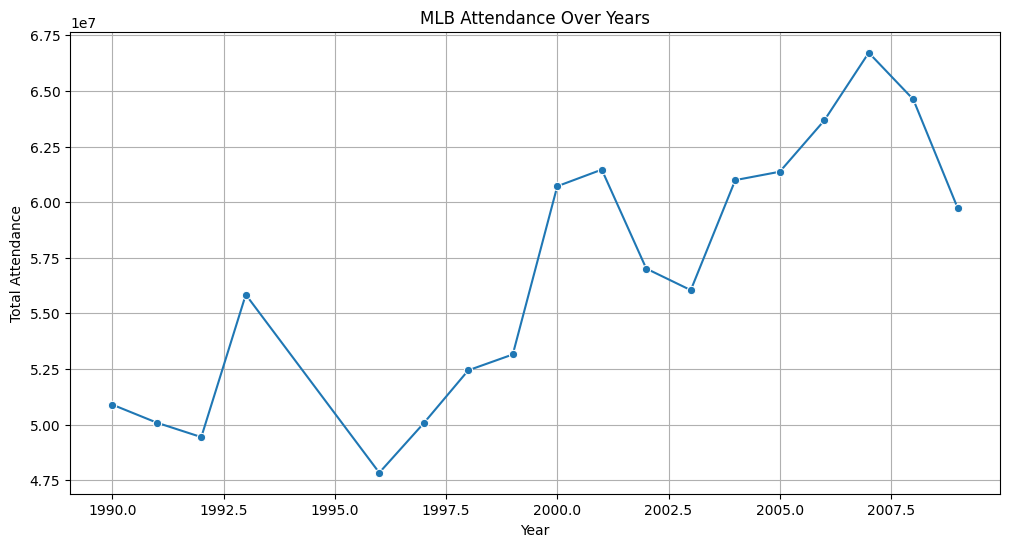

In [15]:
plt.figure(figsize=(12,6))
sns.lineplot(x=attendance_ts.index, y=attendance_ts.values, marker='o')
plt.title('MLB Attendance Over Years')
plt.xlabel('Year')
plt.ylabel('Total Attendance')
plt.grid(True)
plt.show()


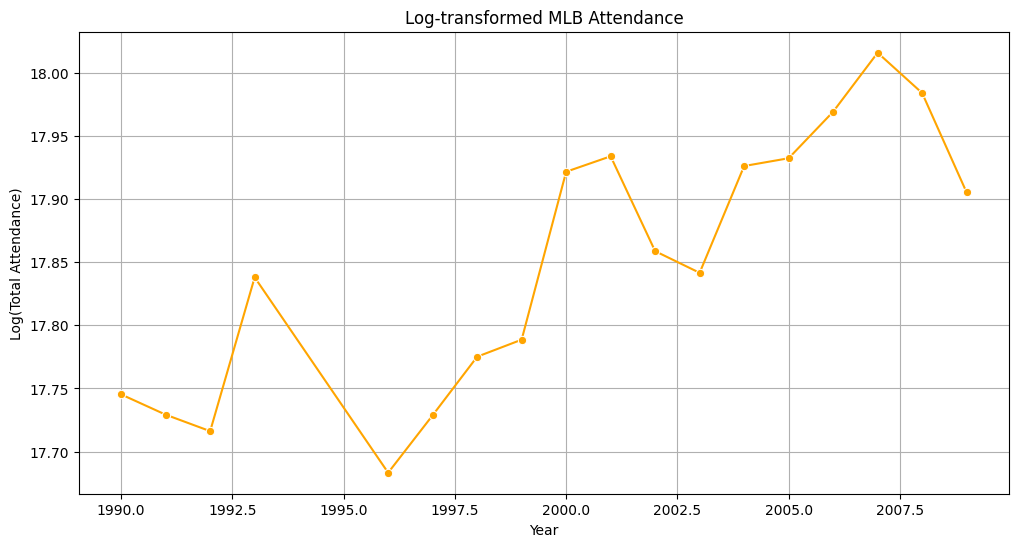

In [17]:
attendance_log = np.log(attendance_ts)

plt.figure(figsize=(12,6))
sns.lineplot(x=attendance_log.index, y=attendance_log.values, marker='o', color='orange')
plt.title('Log-transformed MLB Attendance')
plt.xlabel('Year')
plt.ylabel('Log(Total Attendance)')
plt.grid(True)
plt.show()

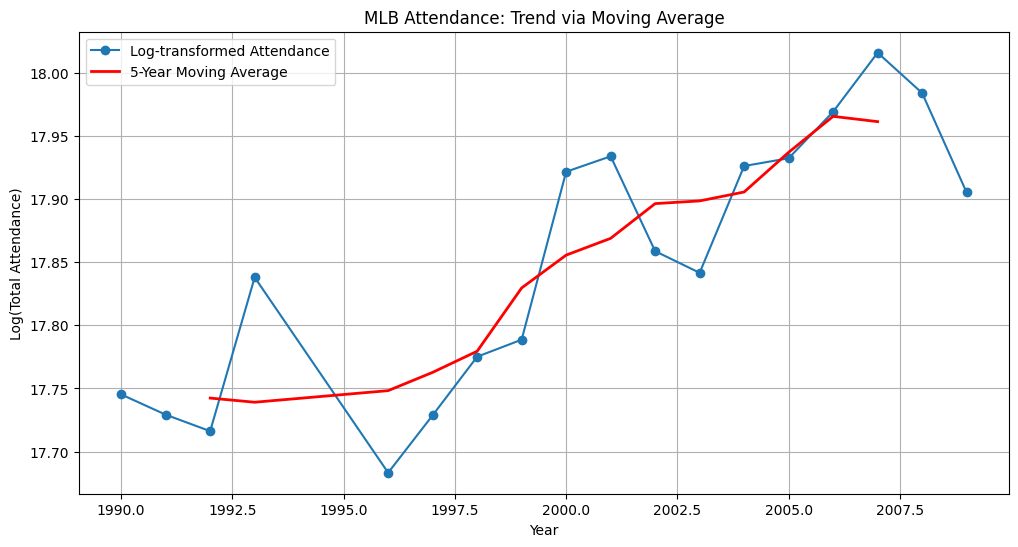

In [18]:
window = 5
attendance_log_ma = attendance_log.rolling(window=window, center=True).mean()

plt.figure(figsize=(12,6))
plt.plot(attendance_log, label='Log-transformed Attendance', marker='o')
plt.plot(attendance_log_ma, label=f'{window}-Year Moving Average', color='red', linewidth=2)
plt.title('MLB Attendance: Trend via Moving Average')
plt.xlabel('Year')
plt.ylabel('Log(Total Attendance)')
plt.legend()
plt.grid(True)
plt.show()


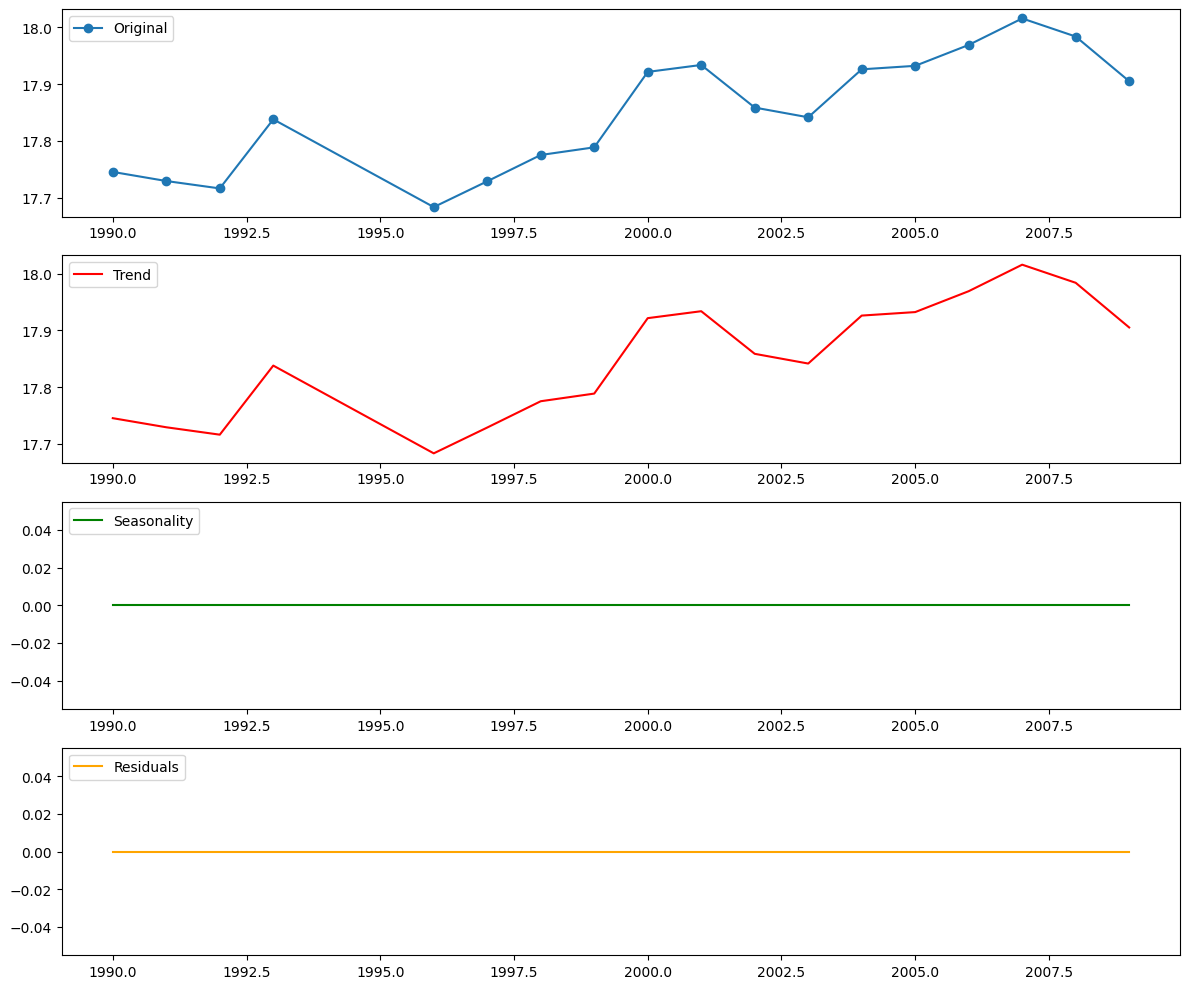

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(attendance_log, model='additive', period=1)  # period=1, т.к. данные по годам

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,10))

plt.subplot(411)
plt.plot(attendance_log, label='Original', marker='o')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='orange')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


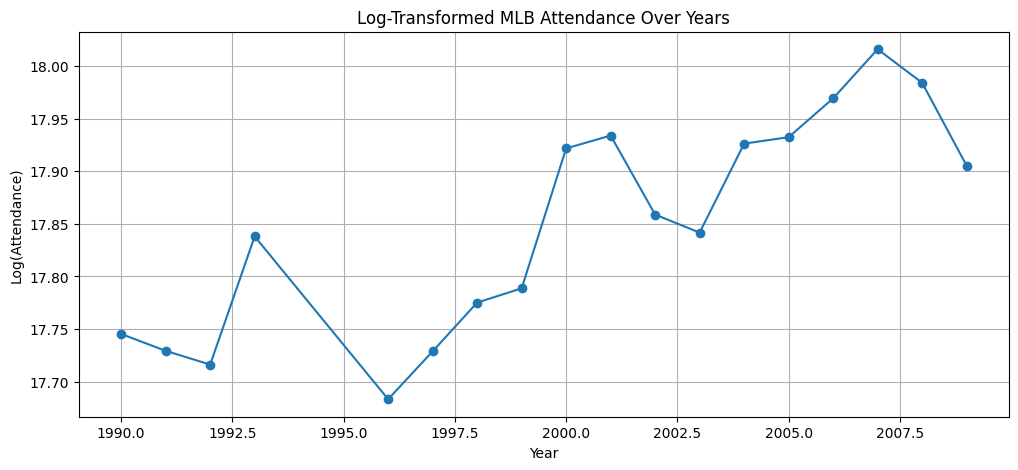

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df_yearly = df.groupby('Year')['Attendance'].sum().to_frame()

attendance_log.index = df_yearly.index


plt.figure(figsize=(12,5))
plt.plot(attendance_log, marker='o')
plt.title("Log-Transformed MLB Attendance Over Years")
plt.xlabel("Year")
plt.ylabel("Log(Attendance)")
plt.grid(True)
plt.show()

<Figure size 1200x400 with 0 Axes>

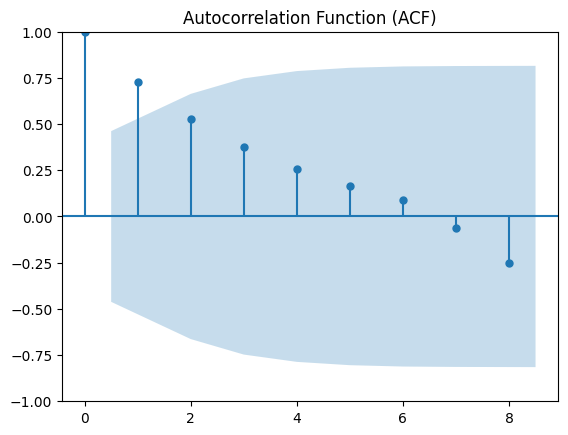

<Figure size 1200x400 with 0 Axes>

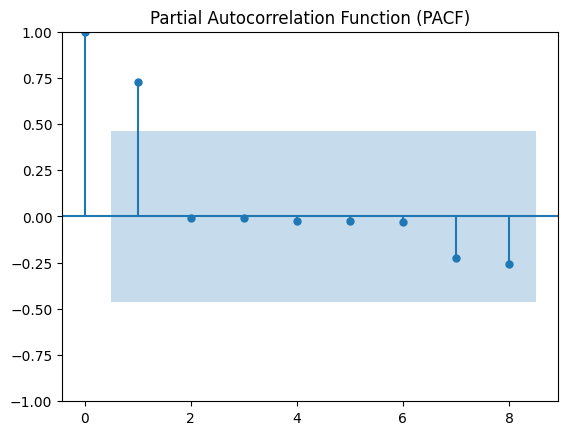

In [27]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Группируем по годам
df_yearly = df.groupby('Year')['Attendance'].sum()

# Логарифмируем для стабилизации дисперсии
attendance_log = np.log(df_yearly)

# Безопасное количество лагов
max_lags = len(attendance_log) // 2 - 1  # строго меньше половины

# ACF
plt.figure(figsize=(12,4))
plot_acf(attendance_log, lags=max_lags)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# PACF
plt.figure(figsize=(12,4))
plot_pacf(attendance_log, lags=max_lags, method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()




In [31]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

In [33]:
attendance_log = attendance_log.dropna()


lb_test = acorr_ljungbox(attendance_log, lags=[10], return_df=True)
print("Ljung-Box test:\n", lb_test)


adf_result = adfuller(attendance_log)
print('\nADF Statistic:', adf_result[0])
print('ADF p-value:', adf_result[1])


kpss_stat, kpss_p, _, _ = kpss(attendance_log, regression='c')
print('\nKPSS Statistic:', kpss_stat)
print('KPSS p-value:', kpss_p)

Ljung-Box test:
       lb_stat  lb_pvalue
10  35.173207   0.000117

ADF Statistic: -5.633800766108281
ADF p-value: 1.0744782628335723e-06

KPSS Statistic: 0.605263750912955
KPSS p-value: 0.022157840826094996


In [34]:
attendance_diff = attendance_log.diff().dropna()
attendance_diff_seasonal = attendance_log.diff(1).dropna()

adf_result_diff = adfuller(attendance_diff)
kpss_stat_diff, kpss_p_diff, _, _ = kpss(attendance_diff, regression='c')

print('ADF p-value after differencing:', adf_result_diff[1])
print('KPSS p-value after differencing:', kpss_p_diff)


ADF p-value after differencing: 0.005604897031973778
KPSS p-value after differencing: 0.1


/tmp/ipython-input-2321275027.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat_diff, kpss_p_diff, _, _ = kpss(attendance_diff, regression='c')


In [36]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")


y = attendance_diff


p = range(0, 4)
d = [0]
q = range(0, 4)

best_aicc = float("inf")
best_order = None
best_model = None


for order in itertools.product(p, d, q):
    try:
        model = ARIMA(y, order=order)
        model_fit = model.fit()
        aicc = model_fit.aicc
        if aicc < best_aicc:
            best_aicc = aicc
            best_order = order
            best_model = model_fit
    except:
        continue

print(f"Лучшая ARIMA модель: {best_order} с AICc = {best_aicc:.2f}")


Лучшая ARIMA модель: (0, 0, 1) с AICc = -40.09


<Figure size 1200x400 with 0 Axes>

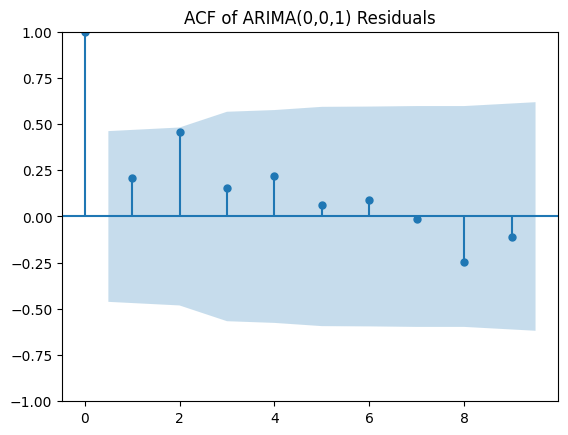

Shapiro-Wilk test statistic: 0.9271, p-value: 0.1724
Остатки распределены нормально (не отвергаем H0)


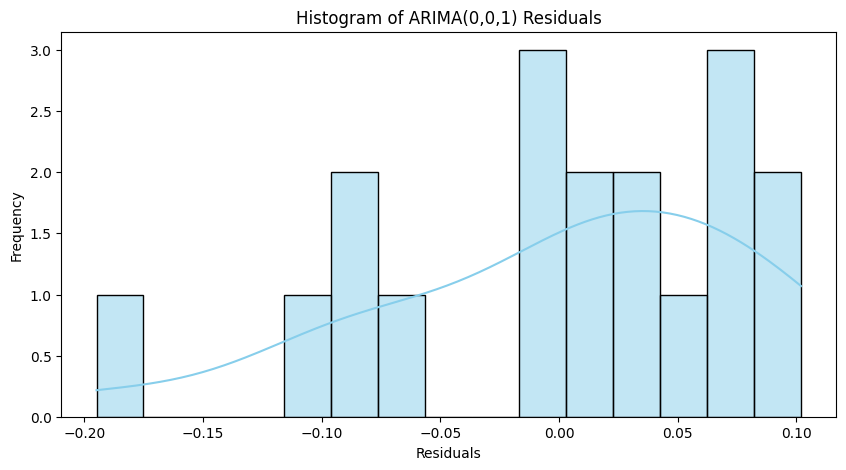

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

residuals = fit_model.resid
n = len(residuals)
lags = min(10, n//2)


plt.figure(figsize=(12,4))
plot_acf(residuals, lags=lags)
plt.title("ACF of ARIMA(0,0,1) Residuals")
plt.show()


stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}")
if p_value > 0.05:
    print("Остатки распределены нормально (не отвергаем H0)")
else:
    print("Остатки не распределены нормально (отвергаем H0)")


plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True, bins=15, color='skyblue')
plt.title("Histogram of ARIMA(0,0,1) Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


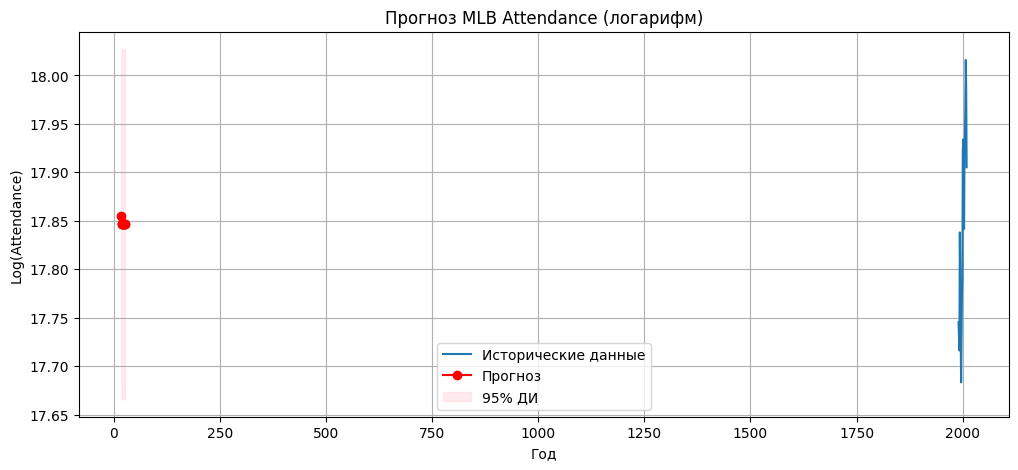

In [41]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(attendance_log, order=(0,0,1))
model_fit = model.fit()


forecast_steps = 10
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()


plt.figure(figsize=(12,5))
plt.plot(attendance_log, label='Исторические данные')
plt.plot(forecast_mean, label='Прогноз', color='red', marker='o')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1], color='pink', alpha=0.3, label='95% ДИ')
plt.title("Прогноз MLB Attendance (логарифм)")
plt.xlabel("Год")
plt.ylabel("Log(Attendance)")
plt.legend()
plt.grid(True)
plt.show()


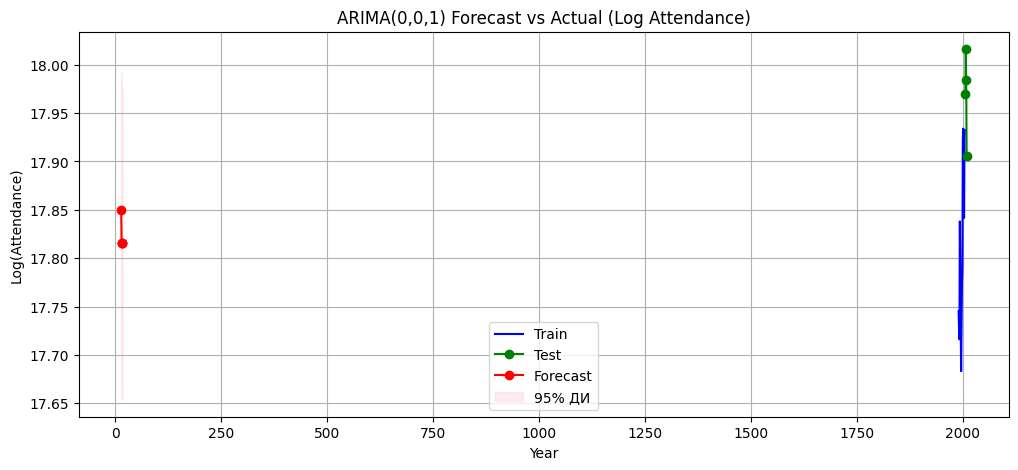

RMSE прогноза: 0.1507


In [43]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np


train_size = int(len(attendance_log) * 0.8)
train, test = attendance_log[:train_size], attendance_log[train_size:]


model = ARIMA(train, order=(0,0,1))
model_fit = model.fit()


forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()


plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green', marker='o')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red', marker='o')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1], color='pink', alpha=0.3, label='95% ДИ')
plt.title("ARIMA(0,0,1) Forecast vs Actual (Log Attendance)")
plt.xlabel("Year")
plt.ylabel("Log(Attendance)")
plt.legend()
plt.grid(True)
plt.show()


from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print(f"RMSE прогноза: {rmse:.4f}")
